In [1]:
%matplotlib inline
import pylab as plt
import seaborn as snb
import numpy as np

from scipy.integrate import odeint
import pystan

snb.set_style('darkgrid')
snb.set(font_scale=1.5)

Adapted from:
 - https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/  
 
 - https://jrmihalj.github.io/estimating-transmission-by-fitting-mechanistic-models-in-Stan/  

### Aux function for plotting

In [2]:
def plot_summary(x, s, interval=95, num_samples=100, sample_color='k', sample_alpha=0.4, interval_alpha=0.25, color='r', legend=True, title="", plot_mean=True, plot_median=False, label="", seed=0):
    
    b = 0.5*(100 - interval)
    
    lower = np.percentile(s, b, axis=0).T
    upper = np.percentile(s, 100-b, axis=0).T
    
    if plot_median:
        median = np.percentile(s, [50], axis=0).T
        lab = 'Median'
        if len(label) > 0:
            lab += " %s" % label
        plt.plot(x.ravel(), median, label=lab, color=color, linewidth=2)
        
    if plot_mean:
        mean = np.mean(s, axis=0).T
        lab = 'Mean'
        if len(label) > 0:
            lab += " %s" % label
        plt.plot(x.ravel(), mean, '--', label=lab, color=color, linewidth=4)
    plt.fill_between(x.ravel(), lower.ravel(), upper.ravel(), color=color, alpha=interval_alpha, label='%d%% Interval' % interval)    
    
    if num_samples > 0:
        np.random.seed(seed)
        idx_samples = np.random.choice(range(len(s)), size=num_samples, replace=False)
        plt.plot(x, s[idx_samples, :].T, color=sample_color, alpha=sample_alpha);
    
    if legend:
        plt.legend(loc='best')
        
    if len(title) > 0:
        plt.title(title, fontweight='bold')


### Simulation ODE

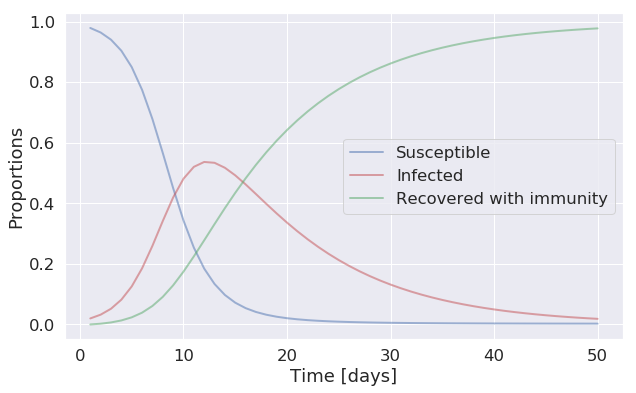

In [3]:
# Total population, N.
N = 1

# Initial number of infected and recovered individuals, I0 and R0.
I0 = 0.02
R0 = 0

# Everyone else, S0, is susceptible to infection initially.
S0 = 1 - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 0.1

# A grid of time points (in days)
t = np.linspace(1, 50, 50)

# The SIR model differential equations.
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time [days]')
ax.set_ylabel('Proportions')
plt.legend()

### Sample observations

In [4]:
np.random.seed(1234)

# number of days, where information is collected
sample_days = 20

# number of host individuals tested per day
sample_n = 25 

# Choose which days the samples were taken. 
sample_times_idx = np.sort(np.random.choice(range(len(t)), size=sample_days, replace=False))
x = t[sample_times_idx]

# Extract the "true" fraction of the population that is infected on each of the sampled days
sample_propinf = I[sample_times_idx]

# Generate binomially distributed data.
y = np.random.binomial(sample_n, p=sample_propinf)



Text(0.5, 1.0, 'Data')

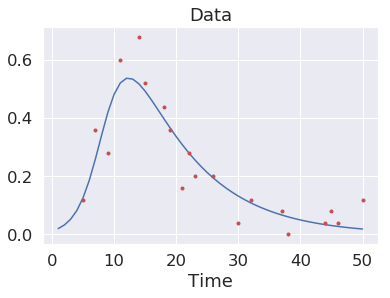

In [5]:
plt.plot(t, I)
plt.plot(x, y/sample_n, 'r.')
plt.xlabel('Time')
plt.title('Data')

### Stan model

In [6]:
stan_model = """
functions {
  
  // This largely follows the deSolve package, but also includes the x_r and x_i variables.
  // These variables are used in the background.
  
  real[] SI(real t,
            real[] y,
            real[] params,
            real[] x_r,
            int[] x_i) {
      
      real dydt[3];
      
      dydt[1] = - params[1] * y[1] * y[2];
      dydt[2] = params[1] * y[1] * y[2] - params[2] * y[2];
      dydt[3] = params[2] * y[2];
      
      return dydt;
    }
  
}

data {
  int<lower = 1> n_obs; // Number of days sampled
  int<lower = 1> n_params; // Number of model parameters
  int<lower = 1> n_difeq; // Number of differential equations in the system
  int<lower = 1> n_sample; // Number of hosts sampled at each time point.
  
  
  int y[n_obs]; // The binomially distributed data
  real t0; // Initial time point (zero)
  real t[n_obs]; // Time points that were sampled
  
  int<lower = 1> n_pred; // This is to generate "predicted"/"unsampled" data
  real t_pred[n_pred]; // Time points for "predicted"/"unsampled" data
}

transformed data {
  real x_r[0];
  int x_i[0];
}

parameters {
  real<lower = 0> params[n_params]; // Model parameters
  real<lower = 0, upper = 1> I0; // Initial fraction of hosts susceptible
}

transformed parameters{
  real y_hat[n_obs, n_difeq]; // Output from the ODE solver
  real y0[n_difeq]; // Initial conditions for both S and I

  y0[2] = I0;
  y0[1] = 1 - I0;
  y0[3] = 0;
  
  y_hat = integrate_ode_rk45(SI, y0, t0, t, params, x_r, x_i);
  
}

model {
  params ~ normal(0, 2); //constrained to be positive
  I0 ~ beta(1, 4);
  
  y ~ binomial(n_sample, y_hat[, 2]); //y_hat[,2] are the fractions infected from the ODE solver
  
}

generated quantities {
  // Generate predicted data over the whole time series:
  real predictions[n_pred, n_difeq];
  
  predictions = integrate_ode_rk45(SI, y0, t0, t_pred, params, x_r, x_i);
  
}

"""

In [7]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1f89973f31281d505d5cbad501f71438 NOW.


In [8]:
data = {'n_obs': sample_days,
        'n_params': 2,
        'n_difeq': 3,
        'n_sample': sample_n,
        'y': y,
        't0': 0,
        't': x,
        'n_pred': len(t),
        't_pred': t}

fit = sm.sampling(data=data, iter=5000, chains=4)

In [9]:
print(fit)

Inference for Stan model: anon_model_1f89973f31281d505d5cbad501f71438.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
params[1]           0.58  1.6e-3    0.1   0.41   0.51   0.58   0.64    0.8   3800    1.0
params[2]           0.09  1.0e-4 7.4e-3   0.08   0.09   0.09    0.1   0.11   5461    1.0
I0                  0.02  3.0e-4   0.02 2.9e-3 9.9e-3   0.02   0.03   0.07   4060    1.0
y_hat[1,1]           0.8  9.8e-4   0.07   0.65   0.76   0.81   0.85   0.91   4793    1.0
y_hat[2,1]          0.62  9.4e-4   0.08   0.46   0.57   0.63   0.68   0.76   6656    1.0
y_hat[3,1]           0.4  7.3e-4   0.07   0.26   0.35   0.41   0.45   0.54   9683    1.0
y_hat[4,1]          0.23  7.3e-4   0.06   0.11   0.19   0.23   0.27   0.36   7214    1.0
y_hat[5,1]           0.1  5.7e-4   0.04   0.03   0.06   0.09   0.12   0.19   5349    1.0
y_hat[6,1

In [10]:
la = fit.extract(permuted=True)

### Predictions

Text(0, 0.5, 'Proportions')

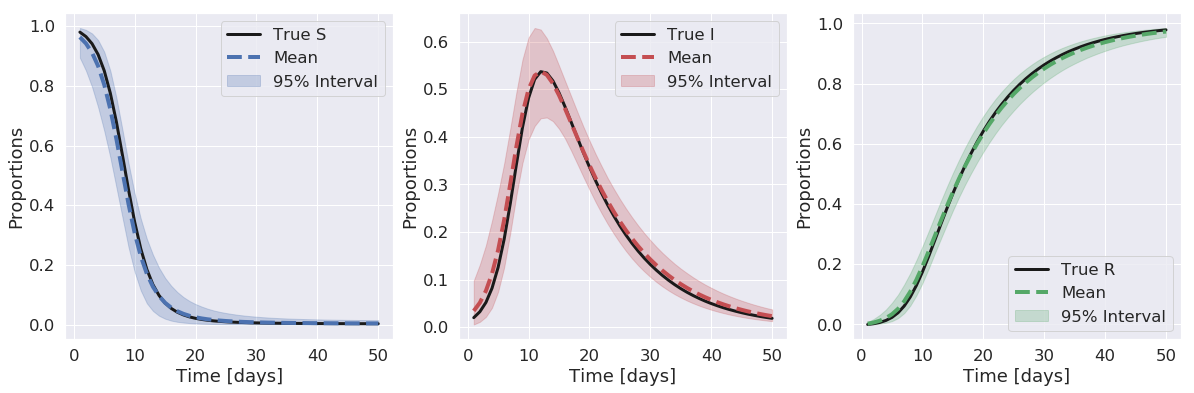

In [11]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.plot(t, S, 'k-', label='True S', linewidth=3)
plot_summary(t, la['predictions'][:, :, 0], num_samples=0, color='b')
plt.xlabel('Time [days]')
plt.ylabel('Proportions')


plt.subplot(1, 3, 2)
plt.plot(t, I, 'k-', label='True I', linewidth=3)
plot_summary(t, la['predictions'][:, :, 1], num_samples=0, color='r')
plt.xlabel('Time [days]')
plt.ylabel('Proportions')

plt.subplot(1, 3, 3)
plt.plot(t, R, 'k-', label='True R', linewidth=3)
plot_summary(t, la['predictions'][:, :, 2], num_samples=0, color='g')
plt.xlabel('Time [days]')
plt.ylabel('Proportions')

### Posterior distribution of parameters

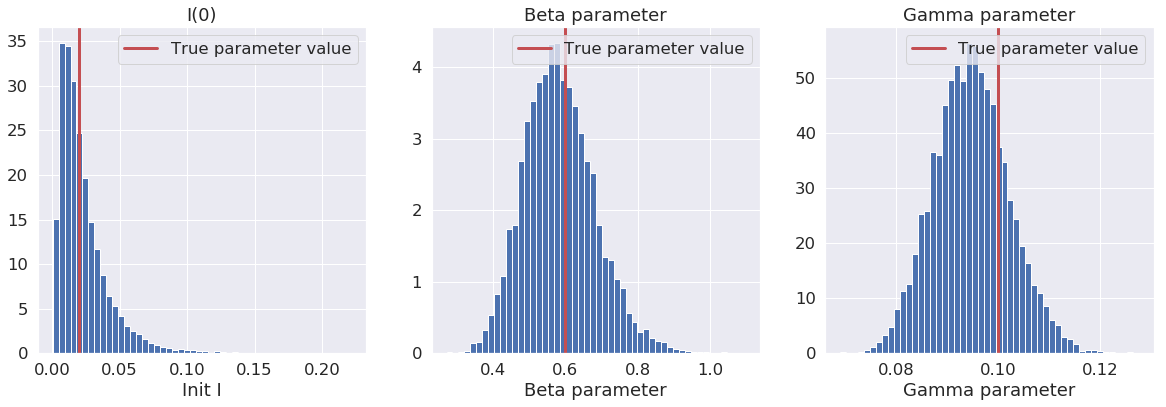

In [12]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.hist(la['I0'], 50, density=True);
plt.xlabel('$I_0$')
plt.axvline(I0, color='r', linewidth=3, label='True parameter value')
plt.xlabel('Init I')
plt.legend()
plt.title('I(0)')

plt.subplot(1, 3, 2)
plt.hist(la['params'][:, 0], 50, density=True);
plt.axvline(beta, color='r', linewidth=3, label='True parameter value')
plt.xlabel('Beta parameter')
plt.legend()
plt.title('Beta parameter')


plt.subplot(1, 3, 3)
plt.hist(la['params'][:, 1], 50, density=True);
plt.axvline(gamma, color='r', linewidth=3, label='True parameter value')
plt.xlabel('Gamma parameter')
plt.title('Gamma parameter')
plt.legend()
